# 로지스틱 회귀 모델를 이용한 감성 분석

In [16]:
# 자연어처리 패키지 설치
!pip install konlpy

> 수집된 데이터 불러오기

In [17]:
# todo 1. 엑셀 데이터 Load
import pandas as pd
from konlpy.tag import Okt
okt = Okt()
data = pd.read_excel('/content/movies_assignment.xlsx')

> 전체 데이터 확인

In [18]:
data

,score,text
0,0,GDNTOPCLASSINTHECLUB
1,0,아앙부터 캐스팅실수인듯 저런인상이 아닌데..
2,0,수업시간에 보면 왠만하면 다 재밌는데 이건 뭐....
3,0,나오미왓츠였다니..
4,0,사지멀쩡한 남자가 좌절해서 인생을포기했는데 여자가 그걸 있는그대로 받아들이고 OO가...
...,...,...
197994,1,정의란 무엇인가 그리고 어떻게 살 것인가 과거현재미래를 아울러 늘상 직면하게되는 화두
197995,1,재미있게 본것 같네요
197996,1,유방이 한신에게 건네준 주먹밥 한덩이
197997,1,아.. 진짜 재미있네.. 간만에 사극 다운 사극 본다


> 데이터 정제하기

In [19]:
# todo 2. 한글과 공백을 남겨두고 모두 제거하도록 2행, 3행의 replace함수의 ()채우기
data['text']=data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 한글을 제외한 문자를 제거하는 정규 표현식 작성
data['text']=data['text'].str.replace('^ +',"", regex=True) # 공백은 empty 값으로 변경
data

,score,text
0,0,
1,0,아앙부터 캐스팅실수인듯 저런인상이 아닌데
2,0,수업시간에 보면 왠만하면 다 재밌는데 이건 뭐
3,0,나오미왓츠였다니
4,0,사지멀쩡한 남자가 좌절해서 인생을포기했는데 여자가 그걸 있는그대로 받아들이고 가는 ...
...,...,...
197994,1,정의란 무엇인가 그리고 어떻게 살 것인가 과거현재미래를 아울러 늘상 직면하게되는 화두
197995,1,재미있게 본것 같네요
197996,1,유방이 한신에게 건네준 주먹밥 한덩이
197997,1,아 진짜 재미있네 간만에 사극 다운 사극 본다


> 결측 값 처리

In [21]:
# text가 비어 있거나(공백), NaN이거나, 문자열 길이가 0인 경우 해당 행을 삭제
data = data[data['text'].fillna('').str.strip() != '']
# document 열의 중복 제거
data.drop_duplicates(subset=['text'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196307 entries, 1 to 197998
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   score   196307 non-null  int64 
 1   text    196307 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.5+ MB


> 긍정과 부정 샘플링 비율 확인

<Axes: xlabel='score'>

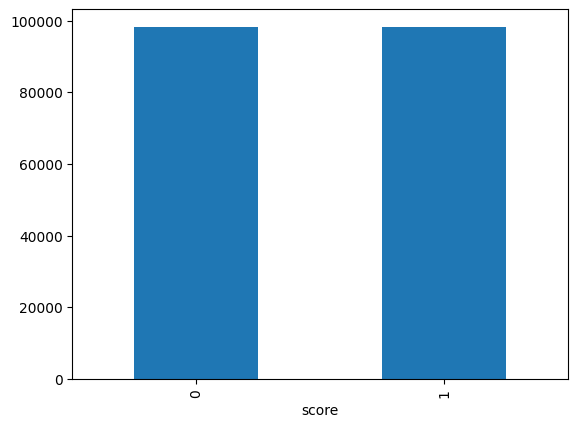

In [22]:
data['score'].value_counts().plot(kind = 'bar')

> 학습용과 테스트 용으로 분리

In [23]:
# 데이터를 문제와 답안으로 나누어 저장
exam = data['text'] # 문제지 분리
ox = data['score'] # 정답지 분리

In [24]:
from sklearn.model_selection import train_test_split
# todo 3. Train용 데이터셋과 Test용 데이터 셋을 7:3 으로 분리하고, 초기값(random_state)을 학번으로 수정
train_x, test_x, train_y, test_y = train_test_split(exam, ox, test_size=0.3, random_state=2025320065)
print(len(train_x), len(train_y), len(test_x), len(test_y))

137414 137414 58893 58893


> TF-IDF 벡터화(단어 빈도-역 문서 빈도: Term Frequency-Inverse Document Frequency)


In [25]:
# 한글 tokenizer
from konlpy.tag import Okt
okt = Okt()

def okt_tokenizer(text):
    return okt.morphs(text)

In [26]:
# 벡터화: 텍스트 데이터를 수치 벡터로 변환하여 머신러닝 모델에 입력할 수 있도록 준비
# todo 4. TF-IDF 벡터화를 위하여 '은', '는' 글자를 불용어(stopwords)로 추가 하시오
# todo 5. ngram의 범위를 1 ~ 2개로 적용할 것
stopwords = ['의','가','이','은','는']
from sklearn.feature_extraction.text import TfidfVectorizer
tfv = TfidfVectorizer(tokenizer=okt_tokenizer, ngram_range=(1,2), stop_words=stopwords)
tfv.fit(train_x) # 벡터를 계산하고 단어의 중요도를 분석하여 내부 어휘 사전을 구성

# 학습 후 입력 데이터를 벡터로 변환
tfv_train_x = tfv.transform(train_x)
tfv_train_x

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3027235 stored elements and shape (137414, 842450)>

> 로지스틱 회귀 모델 학습 + 하이퍼 파라미터 적용

In [30]:
# 하이퍼파라미터(Hyperparameter) 적용 후 학습
from sklearn.linear_model import LogisticRegression # 이진 분류용 모델
from sklearn.metrics import accuracy_score

# todo 6. 다음 모델중 정확도가 가장 높은 모델의 파라미터를 찾아 적용하시오 (주어진 3개 중 하나만 적용)
lf_model = LogisticRegression(random_state=0, C=10, penalty='l2', solver='liblinear')

lf_model.fit(tfv_train_x, train_y)   # 학습하기: 기출문제와 정답 제공
# 테스트 데이터셋으로 예측
tfv_test_x = tfv.transform(test_x)
test_predict = lf_model.predict(tfv_test_x) # 주어진 문제 풀기
# 평가: 정확도 계산, 제출된 답안(text_predict)과 정답(text_y)을 채점
print('영화 감성모델의 테스트 정확도 : {:3.2f}%'.format(accuracy_score(test_y, test_predict)*100))

영화 감성모델의 테스트 정확도 : 86.31%


> 모델 평가

In [31]:
# 모델 평가(파라미터 적용)
tfv_test_x = tfv.transform(test_x)
test_predict = lf_model.predict(tfv_test_x) # 주어진 문제 풀기
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# 제출된 답안(text_predict)과 정답(text_y)을 채점
print('영화 감성모델의 테스트 정확도 : {:3.2f}%'.format(accuracy_score(test_y, test_predict)*100))
# 정밀도, 재현율, f1-score
print('precision: {:.4f}'.format(precision_score(test_y, test_predict)))
print('recall: {:.4f}'.format(recall_score(test_y, test_predict)))
print('f1-score: {:.4f}'.format(f1_score(test_y, test_predict)))

영화 감성모델의 테스트 정확도 : 86.31%
precision: 0.8617
recall: 0.8651
f1-score: 0.8634


> 감성 예측하기

In [32]:
# 감성 예측(파라미터 적용)
import re
input_text = '딱히 대단한 재미도 감동도 없는데 ~! 너무 과대 평과된 영화 중 하나'
print(input_text)
#입력 텍스트에 대한 전처리 수행
input_text = re.compile(r'[ㄱ-ㅣ가-힣]+').findall(input_text)
input_text = [" ".join(input_text)]
# 입력 텍스트의 피처 벡터화
st_tfidf = tfv.transform(input_text)
# 최적 감성 분석 모델에 적용하여 감성 분석 평가
st_predict = lf_model.predict(st_tfidf)
# 확률 계산
st_predict_proba = lf_model.predict_proba(st_tfidf)
#예측 결과 출력
if st_predict == 1:
    print('예측 결과: 긍정 감성 (확률: {:.2f}%)'.format(st_predict_proba[0][1] * 100))
else:
    print('예측 결과: 부정 감성 (확률: {:.2f}%)'.format(st_predict_proba[0][0] * 100))

딱히 대단한 재미도 감동도 없는데 ~! 너무 과대 평과된 영화 중 하나
예측 결과: 부정 감성 (확률: 83.66%)


> 벡터화 결과를 피클로 저장해 두기

In [33]:
# todo 7. 생성된 로지스틱 회귀모델을 피클로 저장될 수 있도록 관련 소스를 찾아 수정하시오
# 학습된 데이터 + 모델 저장하기
import pickle

# 저장할 객체 묶기
save_objects = {
    'tfv': tfv,
    'model': lf_model
}

with open('sentiment_model_Okt_TFv.pickle', 'wb') as f: # pickle 저장
    pickle.dump(save_objects, f)

print("✔ TF-IDF + LogisticRegression 모델 저장 완료!")

✔ TF-IDF + LogisticRegression 모델 저장 완료!
